In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Why compressing signals?

 Commercial echographs perform nonlinear image compression to reduce the dynamic range of the Ultrasound (US) signal in order to improve image visualization. Moreover, the clinician may adjust other parameters, such as brightness, gain and contrast, to improve image quality of a given anatomical detail. These operations significantly change the statistical distribution of the original RF raw signal, which is assumed, based on physical considerations on the signal formation process, to be Rayleigh distributed. Therefore, the image pixels are no longer Rayleigh distributed and the RF signal is not usually available in the common ultrasound equipment. 
 
## Types of compression

* None: absolute value
* sqrt: 
* log:
* alaw:
...

### Defining the ALAW compression below

In [3]:

def alaw_compress(data, data_in_w=15):
    '''
    Input:  np.array with shape (N)
    Output: np.array with shape (N)
    Based on alaw_compress() function in file Software/stl2009/g711/g711.c
    G.191 : Software tools for speech and audio coding standardization
    https://www.itu.int/rec/T-REC-G.191-201901-I/en
    First difference - sign bit is removed and mantissa is expanded up to 5 bits.
    Second difference - XOR 0x55 is not applied to the output data.
    Example of 15 bits to 8 bits compression:
    0000000abcdexxx    000abcde
    0000001abcdexxx    001abcde
    000001abcdexxxx    010abcde
    00001abcdexxxxx    011abcde
    0001abcdexxxxxx    100abcde
    001abcdexxxxxxx    101abcde
    01abcdexxxxxxxx    110abcde
    1abcdexxxxxxxxx    111abcde
    '''
    result_w = 8
    mant_w = 5
    result = np.zeros_like(data)
    for idx, d in enumerate(data):
        tmp_res = d >> (data_in_w - result_w - mant_w + 1)
        exp_val = 0

        # Do more, if exponent > 0
        if (tmp_res > ((2 ** mant_w) - 1)):  # exponent=0 for result <= 31 (mant_w=5)
            exp_val = 1  # first step:
            while(tmp_res > (((2 ** mant_w) - 1) + (2 ** mant_w))):  # find mantissa and exponent
                tmp_res >>= 1
                exp_val += 1
            tmp_res -= 2 ** mant_w  # second step: remove leading '1'
            tmp_res += exp_val << mant_w  # now compute encoded value

        result[idx] = tmp_res
    return np.uint8(result)


def alaw_expand(data, data_out_w=15):
    '''
    Input:  np.array with shape (N)
    Output: np.array with shape (N)
    Based on alaw_expand() function in file Software/stl2009/g711/g711.c
    G.191 : Software tools for speech and audio coding standardization
    https://www.itu.int/rec/T-REC-G.191-201901-I/en
    First difference - sign bit is removed and mantissa is expanded up to 5 bits.
    Second difference - XOR 0x55 is not applied to the input data.
    Example of 8 bits to 15 bits decompression:
    000abcde  0000000abcdexxx
    001abcde  0000001abcdexxx
    010abcde  000001abcdexxxx
    011abcde  00001abcdexxxxx
    100abcde  0001abcdexxxxxx
    101abcde  001abcdexxxxxxx
    110abcde  01abcdexxxxxxxx
    111abcde  1abcdexxxxxxxxx
    Maximum absolute error for this implementation is 256.
    '''
    data_in_w = 8
    result_w = data_out_w
    mant_w = 5
    result = np.uint16(np.zeros_like(data))
    for idx, d in enumerate(data):
        tmp = d
        exp_val = tmp >> mant_w  # extract exponent
        mant_val = tmp & ((2 ** mant_w) - 1)  # now get mantissa
        if (exp_val > 0):
            mant_val = mant_val + (2 ** mant_w)  # add leading '1', if exponent > 0

        mant_val = mant_val << (data_out_w - data_in_w - mant_w + 1)  # now mantissa left justified and
        mant_val = mant_val + (2 ** (result_w - data_in_w - mant_w))  # 1/2 quantization step added

        if (exp_val > 1):  # now left shift according exponent
            mant_val = mant_val << (exp_val - 1)

        result[idx] = mant_val
    return result

In [65]:
data = np.load("data/simple_echo/20201117190350.npz")
signal = data["signal"][0]
SIGNAL =[int(2**15*x) for x in np.abs(signal)/np.max(np.abs(signal))]

# Visualiation of different types of compressions

/home/kelu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


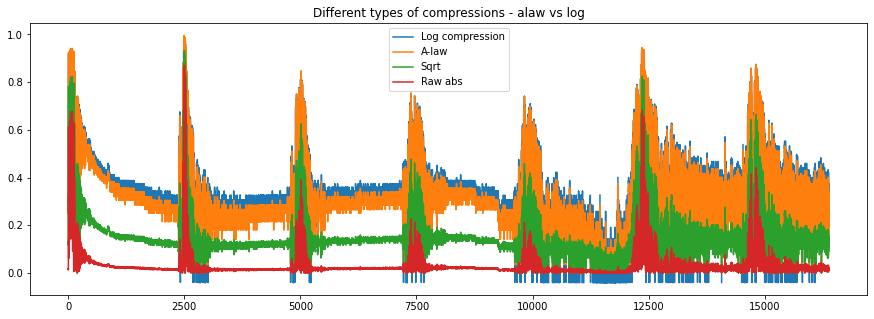

In [66]:
plt.figure(figsize=(15,5))
plt.title("Different types of compressions - alaw vs log")
plt.plot(np.log(np.abs(signal))/6.0+1,label = "Log compression")
plt.plot(alaw_compress(SIGNAL)/256.0,label = "A-law")
plt.plot(np.sqrt(np.abs(signal)),label = "Sqrt")
plt.plot(np.abs(signal),label = "Raw abs")
plt.legend()

In [62]:
img = np.load("data/probeX/outputs/pre_sc.npz")["img"]
img = img / np.max(img)

In [41]:
np.max(img)

1.0

# Impact on images

## No modification

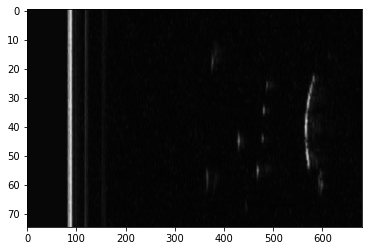

In [42]:
plt.imshow(img,cmap=plt.get_cmap('gray'), aspect='auto')

## Using SQRT

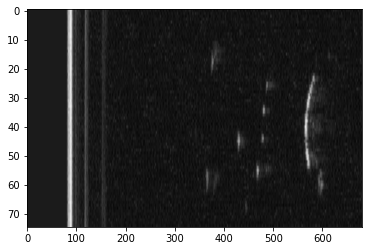

In [48]:
plt.imshow(np.sqrt(img),cmap=plt.get_cmap('gray'), aspect='auto')

## Using LOG

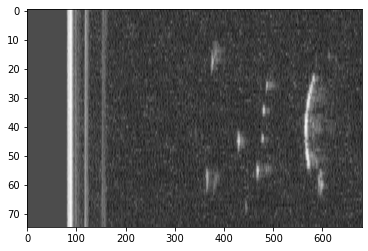

In [50]:
plt.imshow(np.log(img),cmap=plt.get_cmap('gray'), aspect='auto')

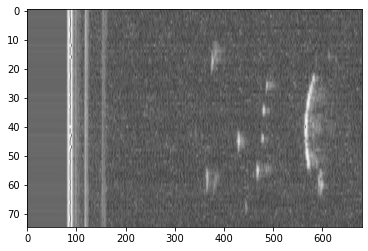

In [68]:
alaw = []
for k in img:
    SIGNAL =[int(2**15*x) for x in np.abs(k)/np.max(np.abs(k))]
    alaw.append(alaw_compress(SIGNAL))
plt.imshow(alaw,cmap=plt.get_cmap('gray'), aspect='auto')